<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ, 2025</b></h3>

<h3 style="text-align: center;"><b>Семинар. Детекция сгенерированных текстов </b></h3>


<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

На этом семинаре мы будем работать с данными из соревнования [Workshop-on-MGT-Detection-Task1 (COLING-2025)](https://github.com/mbzuai-nlp/COLING-2025-Workshop-on-MGT-Detection-Task1/?tab=readme-ov-file)

Этот датасет содержит тексты, написанные человеком, и текстовые генерации нескольких современных языковых моделей. Нам нужно решить задачу бинарной классификации текста на человеческий (real) и сгенерированный (fake).

Установим нужные библиотеки:

In [ ]:
!pip install transformers
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [ ]:
import math
import random
import pandas as pd
import numpy as np
import datasets
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

random.seed(42)
np.random.seed(42)

# Загрузка данных

In [ ]:
atd_dataset = datasets.load_dataset("Jinyan1/COLING_2025_MGT_en")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/588 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/287M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/286M [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/610767 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/261758 [00:00<?, ? examples/s]

In [ ]:
atd_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
        num_rows: 610767
    })
    dev: Dataset({
        features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
        num_rows: 261758
    })
})

Как видно, датасет имеет очень приличный размер. В дальнейшем, с целью ускорения вычислений, мы отфильтруем большую его часть и оставим генерации лишь нескольких моделей. Но сначала посмотрим на исходный список доменов и моделей-генераторов:

In [ ]:
print("Список доменов:")
print(atd_dataset["train"].unique('sub_source'))
print()
print("Список моделей-генераторов:")
print(atd_dataset["train"].unique('model'))
print()
print("Модели-генераторы в train и dev подмножествах совпадают:")
print(set(atd_dataset["train"].unique('model')) == set(atd_dataset["dev"].unique('model')))

Список доменов:
['reddit', 'squad', 'yelp', 'xsum', 'wikipedia', 'reddit_eli5', 'wp', 'roct', 'outfox', 'wikihow', 'sci_gen', 'eli5', 'arxiv', 'cmv', 'tldr', 'peerread', 'hswag', 'finance', 'open_qa', 'imdb', 'wiki_csai', 'dialogsum', 'medicine', 'cnn', 'pubmed']

Список моделей-генераторов:
['llama3-8b', 'human', 'gpt-35', 'GLM130B', '65B', 'text-davinci-003', 'gpt4', 'gpt4o', '7B', 'opt_350m', 'gpt-3.5-turbo', 'cohere', 'davinci', 'mixtral-8x7b', 'gpt_j', 'opt_2.7b', 'flan_t5_small', 'flan_t5_xxl', 'bloomz', 't0_11b', 'opt_iml_max_1.3b', 'text-davinci-002', 'flan_t5_base', 'flan_t5_large', 'bloom_7b', 'opt_30b', 'opt_iml_30b', 'opt_1.3b', 'gpt_neox', 'dolly', '30B', 't0_3b', 'opt_6.7b', 'llama3-70b', 'gemma-7b-it', 'flan_t5_xl', '13B', 'gemma2-9b-it', 'opt_13b', 'dolly-v2-12b', 'opt_125m']

Модели-генераторы в train и dev подмножествах совпадают:
True


### Выбор доменов и моделей, генерации которых мы хотим оставить в нашем датасете

In [ ]:
models_of_interest = {"train": ["human", "gpt-3.5-turbo", "gpt4", "llama3-8b", "llama3-70b"],
                      "dev": ["human", "mixtral-8x7b", "gpt4o", "gemma-7b-it", "gemma2-9b-it"]}
sources_of_interest = {"train": ["reddit"],
                       "dev": ["reddit", "wikipedia", "outfox"]}

splits = {"train": None, "dev": None}

for split in splits:
    splits[split] = atd_dataset[split].filter(
        lambda sample: sample["model"] in models_of_interest[split] and sample["sub_source"] in sources_of_interest[split]
    )
    df = splits[split].to_pandas()
    sampled_df = df.groupby("model").apply(lambda x: x.sample(n=min(1000, len(x)), random_state=42)).reset_index(drop=True)
    splits[split] = datasets.Dataset.from_pandas(sampled_df)

Filter:   0%|          | 0/610767 [00:00<?, ? examples/s]

<ipython-input-6-d09c62e8020c>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby("model").apply(lambda x: x.sample(n=min(1000, len(x)), random_state=42)).reset_index(drop=True)


Filter:   0%|          | 0/261758 [00:00<?, ? examples/s]

<ipython-input-6-d09c62e8020c>:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby("model").apply(lambda x: x.sample(n=min(1000, len(x)), random_state=42)).reset_index(drop=True)


Под моделью "human" в данном датасете подразумеваются тексты, написанные человеком. 😉

In [ ]:
splits

{'train': Dataset({
     features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
     num_rows: 5000
 }),
 'dev': Dataset({
     features: ['id', 'source', 'sub_source', 'lang', 'model', 'label', 'text'],
     num_rows: 5000
 })}

Удостоверимся, что у нас осталось разумное количество генераций по каждой модели и домену

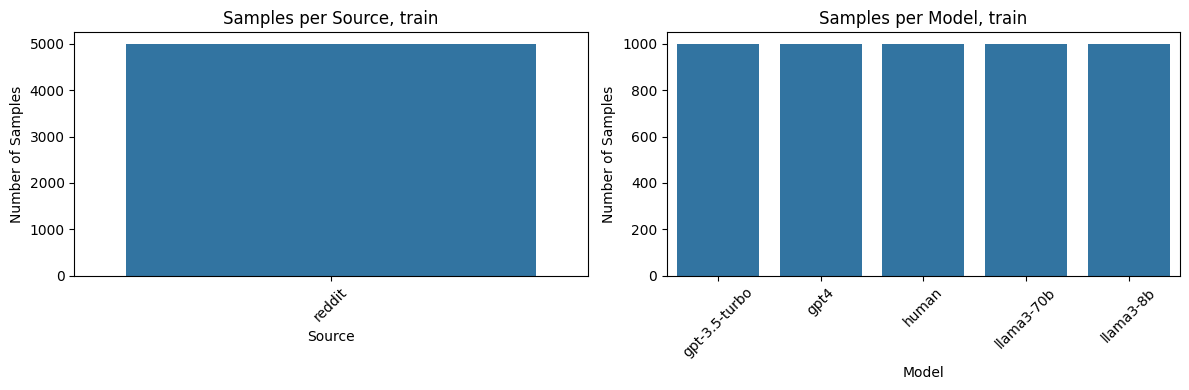

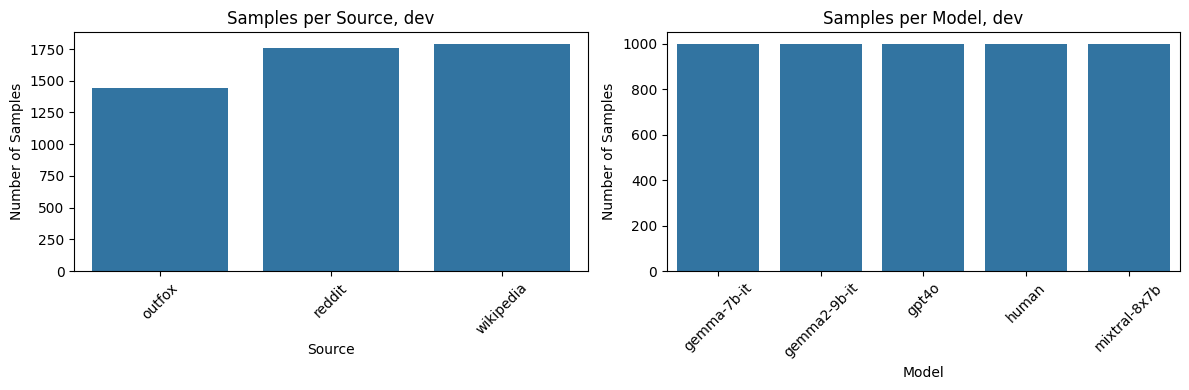

In [ ]:
for split in splits:
    filtered_subset = splits[split]

    sources = [sample["sub_source"] for sample in filtered_subset]
    models = [sample["model"] for sample in filtered_subset]

    source_counts = Counter(sources)
    model_counts = Counter(models)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.barplot(x=list(source_counts.keys()), y=list(source_counts.values()), ax=axes[0])
    axes[0].set_title("Samples per Source, " + split)
    axes[0].set_xlabel("Source")
    axes[0].set_ylabel("Number of Samples")
    axes[0].tick_params(axis="x", rotation=45)

    sns.barplot(x=list(model_counts.keys()), y=list(model_counts.values()), ax=axes[1])
    axes[1].set_title("Samples per Model, " + split)
    axes[1].set_xlabel("Model")
    axes[1].set_ylabel("Number of Samples")
    axes[1].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

# Загрузка модели gpt2

С помощью gpt2 мы будем считать перплексию и отличать сгенерированные тексты от человеческих. Можете поэкспериментировать с другими небольшими LLM (например, Phi-1.5) и посмотреть, как будет отличаться результат.

In [ ]:
model_p = AutoModelForCausalLM.from_pretrained("gpt2", #"microsoft/phi-1.5",
                                             torch_dtype="auto",
                                             trust_remote_code=True,
                                             output_hidden_states=True
                                            )
tokenizer = AutoTokenizer.from_pretrained("gpt2", #"microsoft/phi-1.5",
                                          trust_remote_code=True
                                          )

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
device = "cuda"
model_p = model_p.to(device)

(Напоминание: чтобы использовать cuda-устройство из Google Colab, нужно подключить TPU или GPU в настройках среды выполнения)

# Вычисление средней перплексии по токенам

Напомним, что перплексия текста $x$ длины $t$ считается так:

$$PPL(x) = e^{-\frac{1}{t}\sum \log{p_\theta}(x_i|x_{< i})},$$

где сумма берется по всем отдельным токенам $x_i \in x$, а $\theta$ - параметры модели, перплексию которой мы считаем.

Логарифм перплексии, соответственно, равен negative log likelihood нашей последовательности токенов:

$$\log(PPL(x)) = NLL(x) = -\frac{1}{t}\sum \log{p_\theta}(x_i|x_{< i}).$$

Эту величину, в свою очередь, проще всего вычислять с помощью встроенной функции `ForCausalLMLoss` из библиотеки transformers - её реализацию можно посмотреть здесь: https://github.com/huggingface/transformers/blob/main/src/transformers/loss/loss_utils.py .

Как видно из исходного кода функции, $NLL$ считается через кросс-энтропию между двумя распределениями: одно - истинный текст, а другое - вероятности токенов, предсказанные моделью. В общем виде кросс-энтропия записывается так:

$$CrossEntropy(p, p_\theta) = - \sum_{x_i \in X} p (x_i) \log p_\theta(x_i),$$

где $p$ - истинное распределение над множеством возможных токенов $x_i \in X$, а $p_\theta$ - то, которое выдает модель. Однако, в нашем случае истинное "распределение" схлопнуто до one-hot векторов (вероятность истинного токена равна $1$, в то время как вероятности всех остальных токенов - $0$). Поэтому из всей суммы остается ненулевым только член с вероятностью $p_\theta$ единственного истинного токена, равного $x_i$:

$$\log p_\theta (x') = \log p_\theta (x_i | x_{<i}).$$

После усреднения этой величины по всем $x_i$ из текста как раз и получается $NLL$.

In [ ]:
def calculate_perplexity(text, model, tokenizer, device):
    # Токенизация
    encodings = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    encodings = {k: v.to(device) for k, v in encodings.items()}

    # Вычисление mean negative log-likelihood (nll) per token
    # (стандартный loss для LLM в библиотеке transformers)
    input_ids = encodings["input_ids"]
    with torch.no_grad():
        outputs = model_p(**encodings, labels=input_ids)
        neg_log_likelihood = outputs.loss.item()

    perplexity = math.exp(neg_log_likelihood) # Перплексия вычисляется как e ^ nll
    return perplexity

In [ ]:
perplexity_per_sample = defaultdict(list)

for split in splits: # train, dev
    for sample in tqdm(splits[split]):
        text = sample["text"]
        model_type = sample["model"]  # 'human' or model name
        sub_source = sample["sub_source"]

        try:
            ppl = calculate_perplexity(text, model_p, tokenizer, device)
            perplexity_per_sample[split].append({
                "perplexity": ppl,
                "model": model_type,
                "sub_source": sub_source
            })
        except Exception as e:
            print(f"Error processing sample: {e}")

100%|██████████| 5000/5000 [03:26<00:00, 24.26it/s]


In [ ]:
df

,id,source,sub_source,lang,model,label,text
0,f3963cf1-5b1c-415f-b210-38da71f64244,m4gt,wikipedia,en,mixtral-8x7b,1,Zamyn-Üüd (Mongolian: Замын-Үüd) is a sum (dis...
1,2f61cc25-78e1-4e9e-83a3-72ecf9d09323,m4gt,outfox,en,human,0,Many places all over the world are starting to...
2,e1d5bb8d-94bd-46bf-976d-39a35b63009c,m4gt,reddit,en,human,0,"We really can't know for sure, with the except..."
3,3e412884-26ea-485b-95b9-49d77b6c6895,m4gt,wikipedia,en,human,0,The Town of Ellenboro is a town located in Gra...
4,c40170e4-cec5-4b7b-bd91-24d5a1fb0597,m4gt,wikipedia,en,human,0,Merville-Franceville-Plage () is a commune in ...
...,...,...,...,...,...,...,...
30263,71f75a1c-3db9-47e7-b1ab-ab142ae86f9b,m4gt,reddit,en,gpt4o,1,"Oh, that's a pretty interesting question! So, ..."
30264,01108e2e-49e6-4ea1-96f9-e4f2a9f2bf62,m4gt,outfox,en,mixtral-8x7b,1,Every planet is different and unique in their ...
30265,248aba5a-9137-4039-b5d9-377117d6c6e1,m4gt,outfox,en,human,0,The author has great supports about why we sho...
30266,89a89941-053a-4eaa-83b3-f9b396497f9f,m4gt,wikipedia,en,gemma-7b-it,1,## Sisters of the Infant Jesus\n\nThe Sisters ...


<ipython-input-14-8ffddd6c1044>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="model", y="perplexity", data=df, palette=palette)


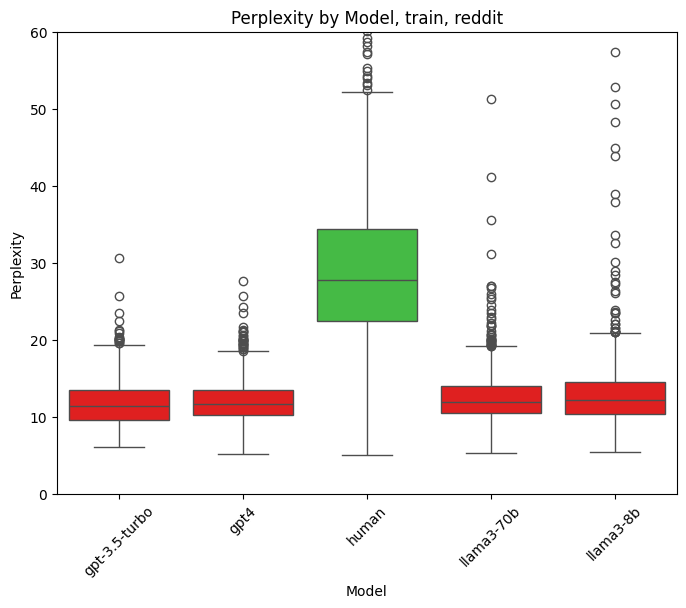

<ipython-input-14-8ffddd6c1044>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="model", y="perplexity", data=df, palette=palette)


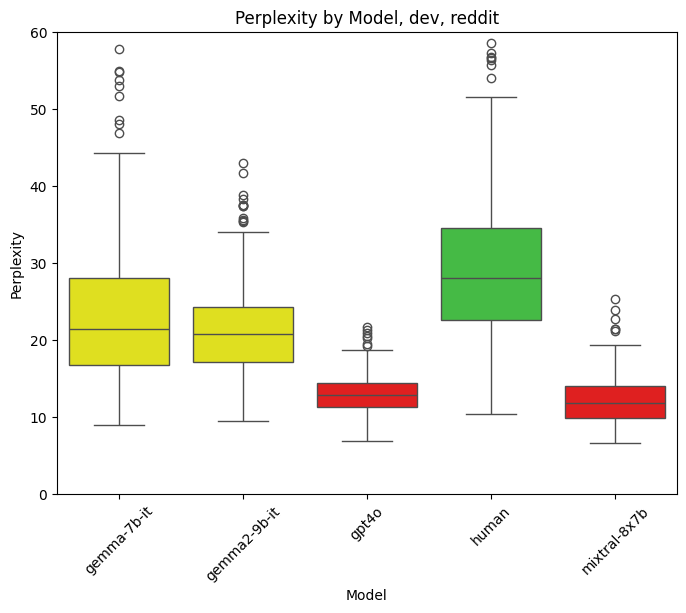

<ipython-input-14-8ffddd6c1044>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="model", y="perplexity", data=df, palette=palette)


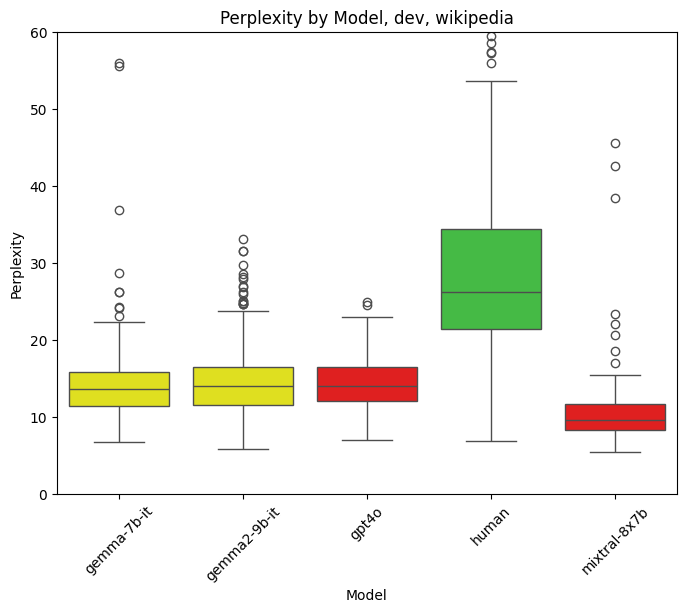

<ipython-input-14-8ffddd6c1044>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="model", y="perplexity", data=df, palette=palette)


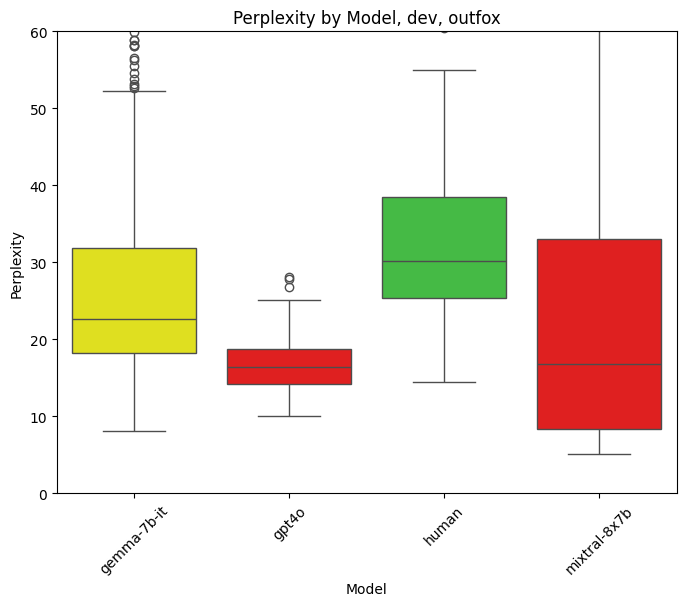

In [ ]:
for split in splits: # train, dev
    for sub_source in sources_of_interest[split]: # wikipedia, reddit etc
        df = pd.DataFrame(perplexity_per_sample[split])
        df = df[df["sub_source"] == sub_source]
        df["model"] = pd.Categorical(df["model"], categories=sorted(df["model"].unique()), ordered=True)

        plt.figure(figsize=(8, 6))
        palette = {}
        for model in df["model"].unique():
            palette[model] = "red"
        palette["gemma-7b-it"] = "yellow"
        palette["gemma2-9b-it"] = "yellow"
        palette["human"] = "limegreen"
        sns.boxplot(x="model", y="perplexity", data=df, palette=palette)
        plt.title("Perplexity by Model, " + split + ", " + sub_source)
        plt.xlabel("Model")
        plt.ylabel("Perplexity")
        plt.ylim(0, 60)
        plt.tick_params(axis="x", rotation=45)
        plt.show()

Как видим, средняя перплексия у человеческих текстов существенно выше, чем у самых популярных моделей - например, моделей линеек gpt и llama. Тем не менее, у некоторых моделей и на некоторых доменах средняя перплексия сгенерированных текстов может быть близко к средней человеческой.

Проверим теперь, насколько хорошо пороговый классификатор, настроенный по нашему train set, классифицировать тексты из dev set:

In [ ]:
len(perplexity_per_sample["dev"])

5000

In [ ]:
train_data = pd.DataFrame(perplexity_per_sample["train"])
train_data["label"] = (train_data["model"] == "human").astype(int)

dev_data = pd.DataFrame(perplexity_per_sample["dev"])
dev_data["label"] = (dev_data["model"] == "human").astype(int)

# Классификация пороговым детектором

### Попробуем подбирать порог на тренировочном множестве наивным образом, выбрав метрику, которую мы желаем максимизировать.

В качестве такой метрики можно взять, например, F1. Обратите внимание на то, что если вместо F1 выбрать для максимизации accuracy, наш классификатор будет ошибочно записывать большинство человеческих текстов в сгенерированные (можете заменить f1_score на accuracy_score в коде внизу и убедиться в этом самостоятельно).

In [ ]:
perplexities = train_data["perplexity"].values
labels = train_data["label"].values

thresholds = np.sort(perplexities)

best_threshold = None
best_f1 = 0

for threshold in thresholds:
    preds = (perplexities > threshold).astype(int)
    f1 = f1_score(labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best threshold: {best_threshold}, Train F1: {best_f1:.3f}")

Best threshold: 19.50911786162287, Train F1: 0.877


Посмотрим теперь, как будет вести себя полученный пороговый детектор на dev множестве.

In [ ]:
dev_data['pred'] = (dev_data['perplexity'] > best_threshold).astype(int)

dev_accuracy = accuracy_score(dev_data['label'], dev_data['pred'])
dev_f1 = f1_score(dev_data['label'], dev_data['pred'])
print(f"Dev Accuracy (Threshold={best_threshold:.2f}): {dev_accuracy:.3f}")
print(f"Dev F1 (Threshold={best_threshold:.2f}): {dev_f1:.3f}")

Dev Accuracy (Threshold=19.51): 0.721
Dev F1 (Threshold=19.51): 0.550


### Сравним качество детекции по моделям

In [ ]:
model_accuracy = dev_data.groupby('model').apply(
    lambda x: accuracy_score(x['label'], x['pred'])
)

print("\nPer-Model Accuracy:")
print(model_accuracy.sort_values())


Per-Model Accuracy:
model
gemma-7b-it     0.500
gemma2-9b-it    0.649
mixtral-8x7b    0.679
human           0.851
gpt4o           0.928
dtype: float64


<ipython-input-19-9a0b03f7a708>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  model_accuracy = dev_data.groupby('model').apply(


In [ ]:
dev_data['pred'] = (dev_data['perplexity'] > best_threshold).astype(int)

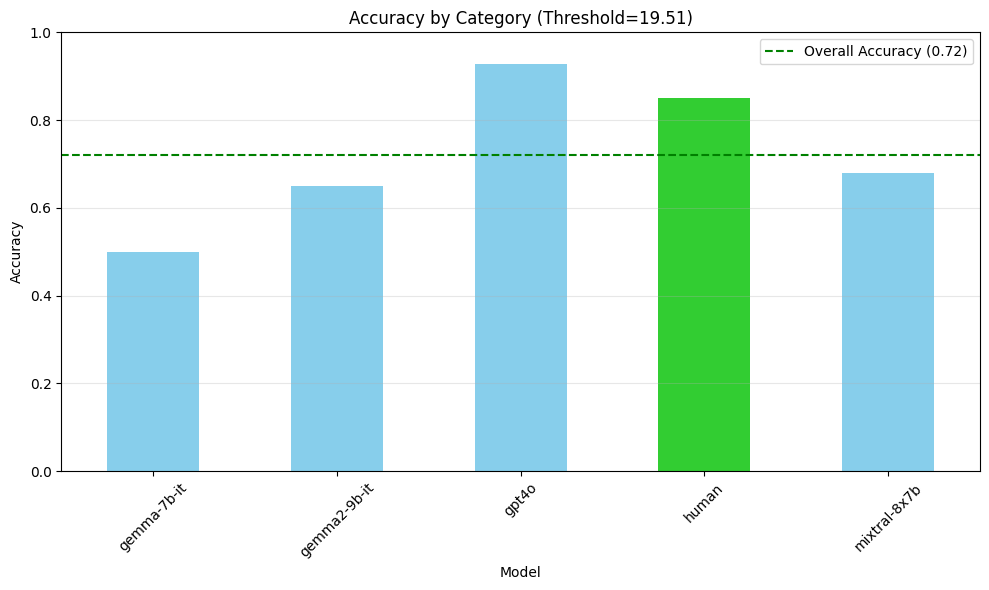

In [ ]:
plt.figure(figsize=(10, 6))

# Create colors list - ensure 'human' gets red regardless of sorting
colors = ['limegreen' if 'human' in str(idx).lower() else 'skyblue' for idx in model_accuracy.index]

# Plot with corrected colors
model_accuracy.plot(kind='bar', color=colors)

plt.axhline(y=dev_accuracy, color='green', linestyle='--', label=f'Overall Accuracy ({dev_accuracy:.2f})')
plt.title(f"Accuracy by Category (Threshold={best_threshold:.2f})")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Как видим, наш классификатор хорошо детектирует популярные модели, но плохо детектирует модели типа gemma. Также он ошибочно отнес часть человеческих текстов к категории машинно-сгенерированных. В реальных детекторах стараются минимизировать вероятность подобных ложных срабатываний.

# Атака на пороговый детектор

Представим теперь, что мы хотим обмануть пороговый детектор, выдав сгенерированные тексты за написанные человеком. Один из возможных вариантов такой атаки - замена части букв в тексте на их омоглифы. Омоглифы — это графически одинаковые или похожие друг на друга знаки, имеющие разное значение; например, омоглифами являются английская "о" и русская "о".

Так, если в английском слове английскую "о" заменить на русский аналог, для человека такое слово визуально не изменится, но перплексия gpt-2 (да и других моделей) на нем резко возрастет, так как для модели слово начнет выглядеть как совершенно другое, малознакомое и маловероятное сочетание токенов. Точно также можно заменять и любые другие символы на визуально похожие, чем мы сейчас и займемся.

### Загрузим список омоглифов из репозитория https://github.com/codebox/homoglyph/

In [ ]:
!wget https://raw.githubusercontent.com/codebox/homoglyph/refs/heads/master/raw_data/chars.txt

--2025-04-16 12:00:11--  https://raw.githubusercontent.com/codebox/homoglyph/refs/heads/master/raw_data/chars.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21977 (21K) [text/plain]
Saving to: ‘chars.txt’

chars.txt           100%[===================>]  21.46K  --.-KB/s    in 0s      

2025-04-16 12:00:12 (83.7 MB/s) - ‘chars.txt’ saved [21977/21977]



In [ ]:
homoglyph_dict = {}
max_homoglyphs_amount = 5

with open("chars.txt", "r") as f:
    for line in f:
        homoglyph_dict[line[0]] = line[1 : max_homoglyphs_amount+1].strip()

### Заменим символы из каждого искуственно сгенерированного текста в dev на их омоглифы с вероятностью 2%

(при условии, что символ есть в словаре)

In [ ]:
def homoglyph_attack(text, p=0.5):
    homoglyph_text = []
    for c in text:
        if c in homoglyph_dict and len(homoglyph_dict[c]) >= 1 and random.random() < p:
            new_c = random.choice(list(homoglyph_dict[c]))
        else:
            new_c = c
        homoglyph_text.append(new_c)
    return "".join(homoglyph_text)

In [ ]:
attacked_dev = deepcopy(splits["dev"])
attacked_text = []

for i in tqdm(range(len(attacked_dev))):
    sample = attacked_dev[i]
    if sample["model"] != "human":
        attacked_text.append(homoglyph_attack(sample["text"], p=0.02))
    else:
        attacked_text.append(sample["text"])

100%|██████████| 5000/5000 [00:02<00:00, 2171.93it/s]


In [ ]:
len(attacked_text), len(attacked_dev)

(5000, 5000)

In [ ]:
attacked_dev = attacked_dev.remove_columns("text")
attacked_dev = attacked_dev.add_column("text", attacked_text)

### Посчитаем перплексию на текстах, к которым применена наша атака

In [ ]:
splits["attacked_dev"] = attacked_dev
split = "attacked_dev"

for sample in tqdm(splits[split]):
    text = sample["text"]
    model_type = sample["model"]  # 'human' or model name
    sub_source = sample["sub_source"]

    ppl = calculate_perplexity(text, model_p, tokenizer, device)
    perplexity_per_sample[split].append({
        "perplexity": ppl,
        "model": model_type,
        "sub_source": sub_source
    })

100%|██████████| 5000/5000 [03:36<00:00, 23.13it/s]


<ipython-input-29-0e075e51a944>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="model", y="perplexity", data=df_dev, palette=palette, ax=axes[0])  # Plot on the left subplot
<ipython-input-29-0e075e51a944>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="model", y="perplexity", data=df_attacked, palette=palette, ax=axes[1])  # Plot on the right subplot


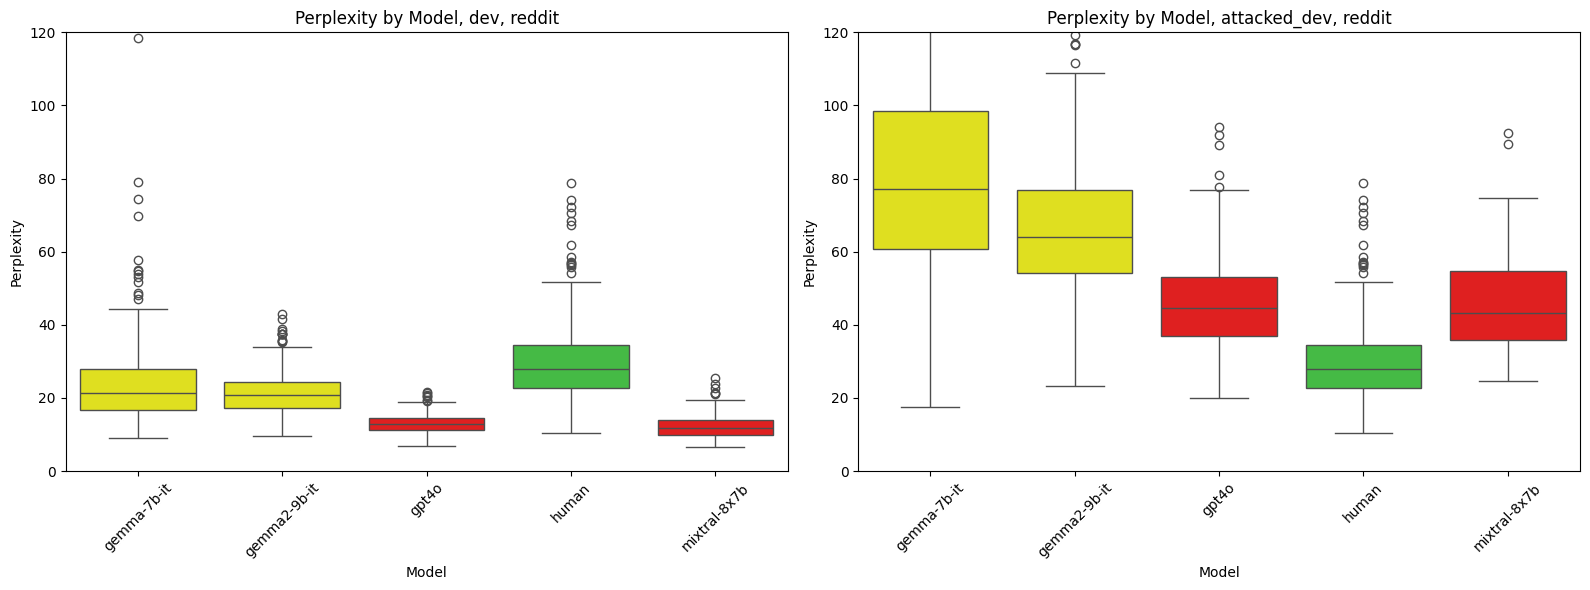

<ipython-input-29-0e075e51a944>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="model", y="perplexity", data=df_dev, palette=palette, ax=axes[0])  # Plot on the left subplot
<ipython-input-29-0e075e51a944>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="model", y="perplexity", data=df_attacked, palette=palette, ax=axes[1])  # Plot on the right subplot


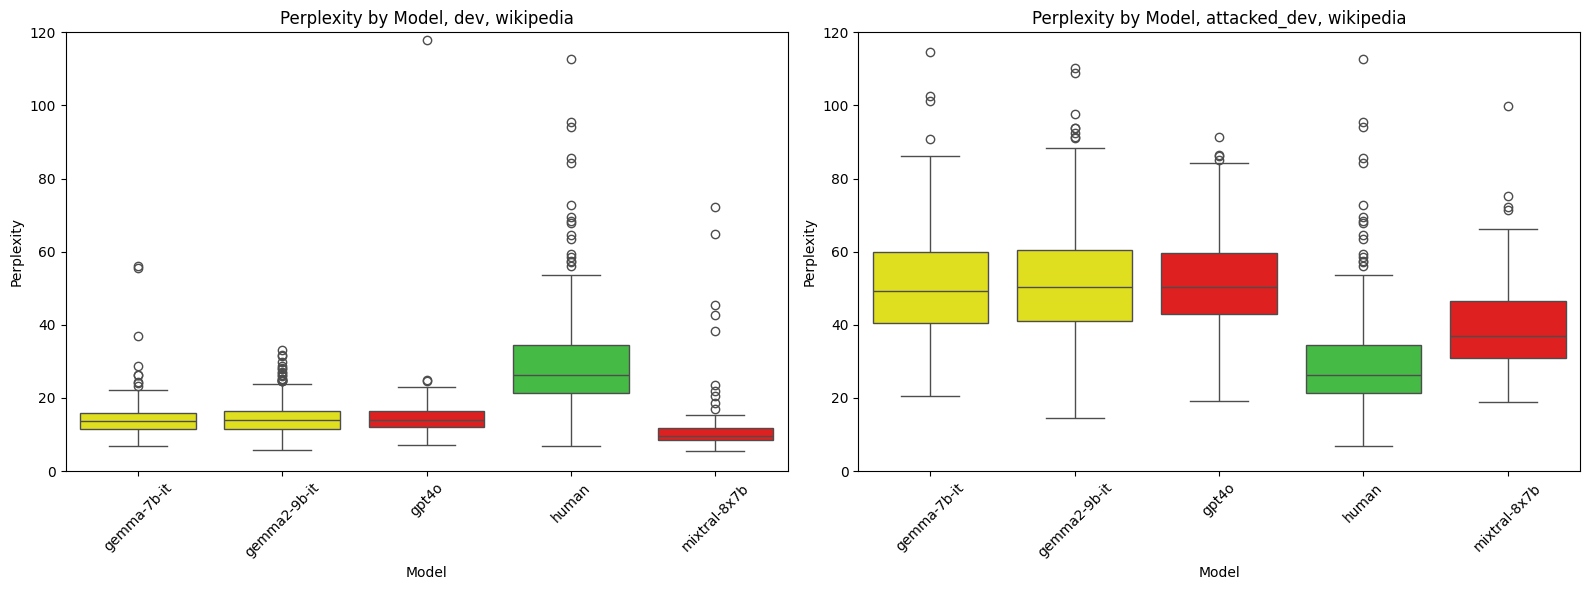

<ipython-input-29-0e075e51a944>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="model", y="perplexity", data=df_dev, palette=palette, ax=axes[0])  # Plot on the left subplot
<ipython-input-29-0e075e51a944>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="model", y="perplexity", data=df_attacked, palette=palette, ax=axes[1])  # Plot on the right subplot


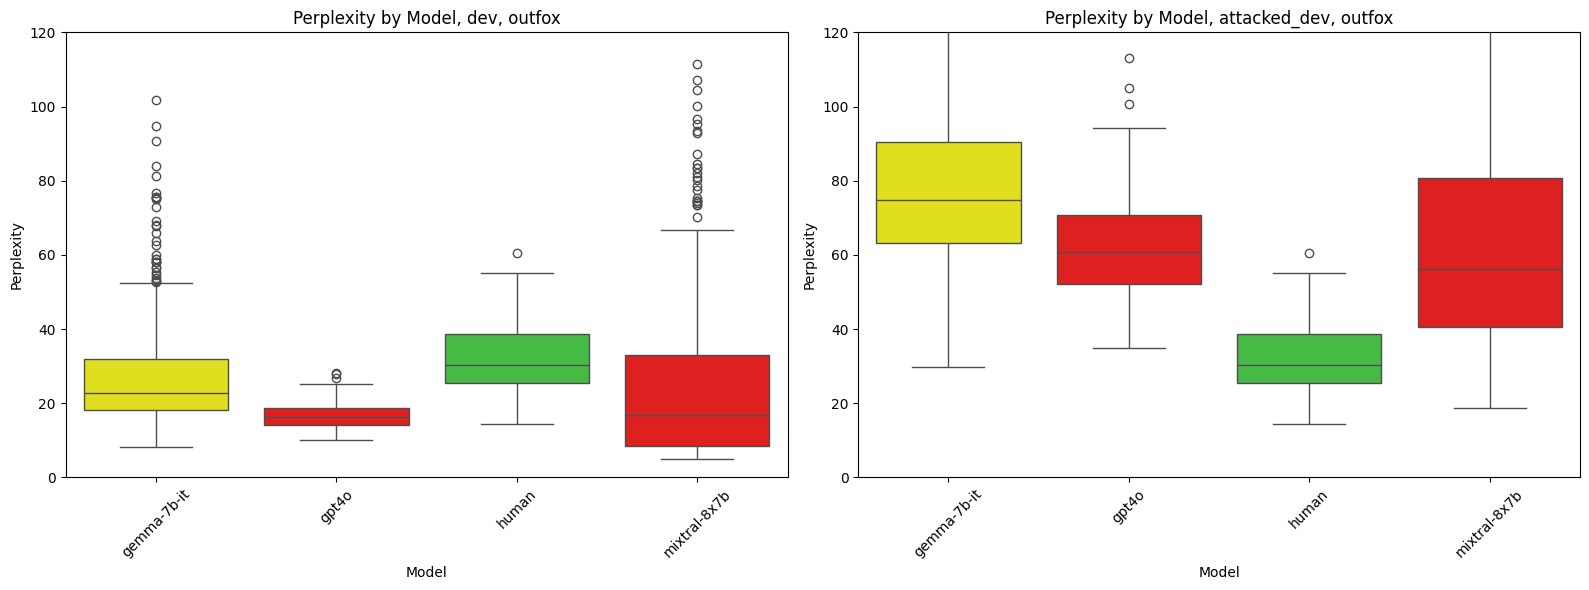

In [ ]:
sources_of_interest["attacked_dev"] = sources_of_interest["dev"]

for sub_source in sources_of_interest["dev"]:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Create 2 subplots

    # Boxplot for 'dev' data
    df_dev = pd.DataFrame(perplexity_per_sample["dev"])
    df_dev = df_dev[df_dev["sub_source"] == sub_source]
    df_dev["model"] = pd.Categorical(df_dev["model"], categories=sorted(df_dev["model"].unique()), ordered=True)
    palette = {}
    for model in df_dev["model"].unique():
        palette[model] = "red"
    palette["gemma-7b-it"] = "yellow"
    palette["gemma2-9b-it"] = "yellow"
    palette["human"] = "limegreen"
    sns.boxplot(x="model", y="perplexity", data=df_dev, palette=palette, ax=axes[0])  # Plot on the left subplot
    axes[0].set_title("Perplexity by Model, dev, " + sub_source)
    axes[0].set_xlabel("Model")
    axes[0].set_ylabel("Perplexity")
    axes[0].set_ylim(0, 120)
    axes[0].tick_params(axis="x", rotation=45)

    # Boxplot for 'attacked_dev' data
    df_attacked = pd.DataFrame(perplexity_per_sample["attacked_dev"])
    df_attacked = df_attacked[df_attacked["sub_source"] == sub_source]
    df_attacked["model"] = pd.Categorical(df_attacked["model"], categories=sorted(df_attacked["model"].unique()), ordered=True)
    sns.boxplot(x="model", y="perplexity", data=df_attacked, palette=palette, ax=axes[1])  # Plot on the right subplot
    axes[1].set_title("Perplexity by Model, attacked_dev, " + sub_source)
    axes[1].set_xlabel("Model")
    axes[1].set_ylabel("Perplexity")
    axes[1].set_ylim(0, 120)
    axes[1].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()

Как видим, достаточно было заменить всего 2% символов на гомоглифы, чтобы перплексия наших сгенерированных текстов резко возросла. При этом внешний вид текстов поменялся совсем немного, и они остались человеко-читаемыми:

In [ ]:
attacked_dev[0]

{'id': 'e0b84d87-a68d-4aa5-960b-ffaafdc51aa7',
 'source': 'm4gt',
 'sub_source': 'outfox',
 'lang': 'en',
 'model': 'gemma-7b-it',
 'label': 1,
 'text': '## A C is Enough: Rethinking Paᴦticipation Grade Requirements\n\nEnsuring student engagement in extracurricular activities is paramount in fosｔering well-rounded individuals. Hoԝever, requiring a high academic performance flooг, such as a B average, for participation unfairly limits access and overlooks the diverse talents and abilities of students. By implementing a more inclusive apⲣroach where a C average is Ꮷeemed ƽufficient, schools can nurture a broader range of students and cultivate a wider spectrum of skills and interests.\n\nFirstly, labeling students as ineligible for extracurricular activities solely based on their academic performance excludes students who maү eᕁcel in other areas. Students who may struggle academically may possess exceptional artistic, musical, or athletic talℯnts, qualities that are vital for creating a

In [ ]:
attacked_dev[1000]

{'id': 'f863f55d-ba43-4d25-be67-2ed4be684370',
 'source': 'm4gt',
 'sub_source': 'reddit',
 'lang': 'en',
 'model': 'gemma2-9b-it',
 'label': 1,
 'text': "S⍺ruman's fall from grace and subsequent defection to Sauron is a complex and tragic tale, driven by a confluence of factors. At the heart of it lies his profound ambition and a growing pride excⅇeding even the most venℯrable of Istaⲅi. Once a skilled wizard, adorned with intellect and ᴡisdom by hiｓ Valar creators, Saruman becamҽ captivated by his own perceived greatness. He craved power, not for the good of Middle-earth but for doｍi𝐧ion over it.\n\nHis position as the head of the White Council, entrusted with the task of combating Sauron's resurgence, was but a stepping ꜱtone. Saruman saw in Sauron's might an opportunity, not a threat. He believed that aligning himｓelf with the Dark Lord would grant him the power to shape Middle-earth according to ℎis own vision, even if it meant sacrificing the free will and destinies of its inｈabi

### Посмотрим, как произошедшее повлияло на наш детектор

In [ ]:
attacked_dev_data = pd.DataFrame(perplexity_per_sample["attacked_dev"])

attacked_dev_data['label'] = (attacked_dev_data['model'] == 'human').astype(int)
attacked_dev_data['pred'] = (attacked_dev_data['perplexity'] > best_threshold).astype(int)

attacked_dev_accuracy = accuracy_score(attacked_dev_data['label'], attacked_dev_data['pred'])
attacked_dev_f1 = f1_score(attacked_dev_data['label'], attacked_dev_data['pred'], zero_division=0)
print(f"Dev Accuracy (Threshold={best_threshold:.2f}): {attacked_dev_accuracy:.3f}")
print(f"Dev F1 (Threshold={best_threshold:.2f}): {attacked_dev_f1:.3f}")

model_accuracy = attacked_dev_data.groupby('model').apply(
    lambda x: accuracy_score(x['label'], x['pred'])
)

print("\nPer-Model Accuracy:")
print(model_accuracy.sort_values())

Dev Accuracy (Threshold=19.51): 0.172
Dev F1 (Threshold=19.51): 0.291

Per-Model Accuracy:
model
gemma-7b-it     0.001
gpt4o           0.001
gemma2-9b-it    0.002
mixtral-8x7b    0.004
human           0.851
dtype: float64


<ipython-input-32-9311631089b3>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  model_accuracy = attacked_dev_data.groupby('model').apply(


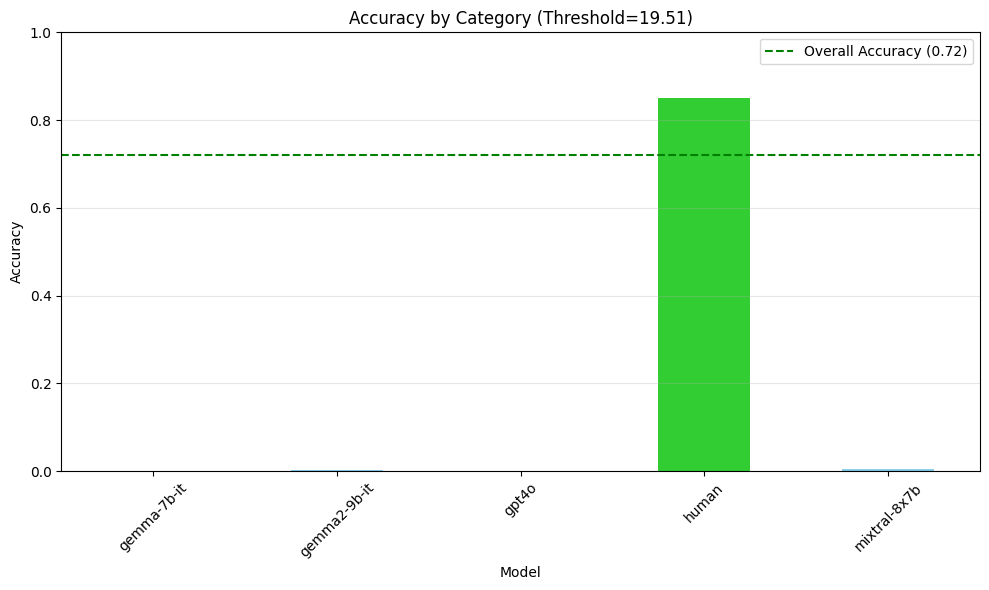

In [ ]:
plt.figure(figsize=(10, 6))

# Create colors list - ensure 'human' gets red regardless of sorting
colors = ['limegreen' if 'human' in str(idx).lower() else 'skyblue' for idx in model_accuracy.index]

# Plot with corrected colors
model_accuracy.plot(kind='bar', color=colors)

plt.axhline(y=dev_accuracy, color='green', linestyle='--', label=f'Overall Accuracy ({dev_accuracy:.2f})')
plt.title(f"Accuracy by Category (Threshold={best_threshold:.2f})")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Как видим, качество детекции сгенерированных текстов упало настолько, что детектор стал практически бесполезен.